### Exercise Sheet 3

#### 3.1 Learning the Solution Operator
Use TorchPhysics and DeepONets to solve the ODE with time dependent $D(t)$:

\begin{align*}
    \partial_t^2 u(t) &= D(t)(\partial_t u(t))^2 - g \\
    u(0) &= H \\
    \partial_t u(0) &= 0
\end{align*}

If you are using Google Colab, you first have to install TorchPhysics with the following cell. We recommend first enabling the GPU and then running the cell. Since the installation can take around 2 minutes and has to be redone if you switch to the GPU later.

In [1]:
!pip install torchphysics

In [2]:
import torch
import torchphysics as tp
import pytorch_lightning as pl

# Here all parameters are defined:
t_min, t_max = 0.0, 3.0
g, H = 9.81, 50.0
D_min, D_max = 0.005, 5.0
# Size of the data set
data_batch = 12000

# Number of time points for discretization of D and training
N_t = 60

# Training parameters
train_iterations = 7500
learning_rate = 5.e-4

In [3]:
# Function that uses backward Euler to create the dataset (you dont have to understand this cell):
def data_create_fn(N_t, data_batch, start_height):
    # Time grid (Trunk input)
    t = torch.linspace(0, 3.0, 60)
    dt = t[1] - t[0]
    # Tensors for Branch input and expected output
    D_fn = torch.zeros((data_batch, len(t), 1))
    u = torch.zeros((data_batch, len(t), 1))
    v = torch.zeros((data_batch, len(t), 1))
    
    # Create different fuction types for D_fn:
    # First batch are step functions:
    ind = int(data_batch / 3.0)
    random_steps = D_min + (D_max - D_min) * torch.rand((ind, 6, 1))
    D_fn[:ind, :] = random_steps.repeat_interleave(int(N_t/6), dim=1)
    # Second batch are sinus functions:
    random_fre_amp = D_min + (D_max - D_min) * torch.rand((ind, 1, 2))
    random_fre_amp = random_fre_amp.repeat_interleave(N_t, dim=1)
    sin_fn = random_fre_amp[:, :, 1]/2.0 * (D_min + 1 + torch.sin(random_fre_amp[:, :, 0] * t))
    D_fn[ind:2*ind, :] = sin_fn.unsqueeze(-1)
    # Last batch is exp functions:
    missing_idx = data_batch - 2*ind
    random_start_sloope = (D_max - D_min) * torch.rand((missing_idx, 1, 2))
    random_start_sloope = random_start_sloope.repeat_interleave(N_t, dim=1)
    exp_fn = D_min + random_start_sloope[:, :, 1] * torch.exp(-random_start_sloope[:, :, 0] * t)
    D_fn[2*ind:, :] = exp_fn.unsqueeze(-1)
    # flip some exp functions around t=1.5:
    D_fn[int(2*ind + missing_idx/2.0):, :] = torch.flip(D_fn[int(2*ind + missing_idx/2.0):, :, :], dims=(1,))
    
    # Do time stepping to compute solution
    u[:, 0] = start_height
    for i in range(len(t)-1):
        v[:, i+1] = 1/(2*dt*D_fn[:, i+1]) - torch.sqrt(1/(2*dt*D_fn[:, i+1])**2 - (v[:, i] - dt*g)/(dt*D_fn[:, i+1]))
        u[:, i+1] = u[:, i] + dt * v[:, i+1]

    return t.reshape(-1, 1), u, D_fn[:, ::2, :]

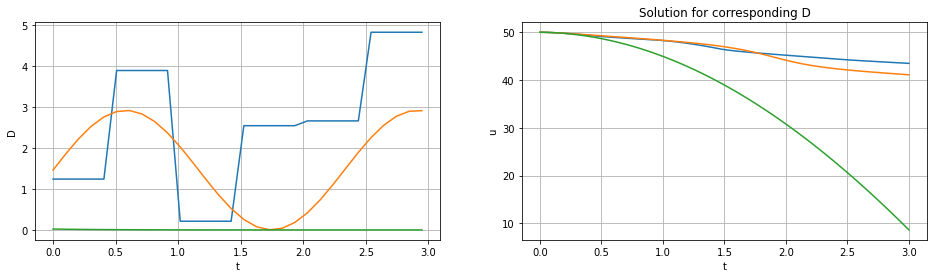

In [4]:
# Here we create the data
t_tensor, u_tensor, D_tensor = data_create_fn(N_t, data_batch, H)

# Show an example plot
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(t_tensor[::2], D_tensor[0])
plt.plot(t_tensor[::2], D_tensor[4000])
plt.plot(t_tensor[::2], D_tensor[8000])
plt.ylabel("D")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(t_tensor, u_tensor[0])
plt.plot(t_tensor, u_tensor[4000])
plt.plot(t_tensor, u_tensor[8000])
plt.ylabel("u")
plt.xlabel("t")
plt.title("Solution for corresponding D")
plt.grid()

#### a) Shuffle and Split Data 
The above data is created in ordered way (e.g. first 4000 entries belong to step functions). Randomly permute the tensors of $u$ and $D$ along the batch dimension and then split both tensors into a training set consisting of 80% of the data and a testing set with the remaining 20%.

**Hint** for the shuffling `torch.randperm` may be useful.

In [5]:
### TODO: Permute data of u, D and split them into two sets (training and testing)

# permute ....
permutation = torch.randperm(len(D_tensor))
u_tensor = u_tensor[permutation]
D_tensor = D_tensor[permutation]

# Then split
u_tensor_train = u_tensor[:10000]
D_tensor_train = D_tensor[:10000]
u_tensor_test = u_tensor[10000:]
D_tensor_test = D_tensor[10000:]

Now we start with the TorchPhysics part

In [6]:
# Spaces 
T = tp.spaces.R1('t') # input variable
U = tp.spaces.R1('u') # output variable
D = tp.spaces.R1('D') # function output space name

# Domain
int_x = tp.domains.Interval(T, t_min, t_max)

# Space that collects the Branch functions
Fn_space = tp.spaces.FunctionSpace(int_x, D)
discretization_sampler = tp.samplers.DataSampler(tp.spaces.Points(t_tensor[::2], T))

In [7]:
output_neurons = 25
branch_net = tp.models.FCBranchNet(Fn_space, discretization_sampler, (30,30,30))
trunk_net  = tp.models.FCTrunkNet(T, (30,30,30))
deepOnet   = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons)

In [8]:
branch_batch_size = len(u_tensor_train)
trunk_batch_size  = len(t_tensor)
dataloader = tp.utils.DeepONetDataLoader(D_tensor_train, t_tensor, u_tensor_train, D, T, U,
                                         branch_batch_size, trunk_batch_size)

In [9]:
data_condition = tp.conditions.DeepONetDataCondition(deepOnet, dataloader, 2, root=2)

In [10]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate) 
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)


trainer = pl.Trainer(gpus=1,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=train_iterations,
                     logger=False
                     )

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 6.3 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
6.3 K     Trainable params
0         Non-trainable params
6.3 K     Total params
0.025     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: User

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [11]:
# Check error on test set:
u_model = deepOnet(tp.spaces.Points(t_tensor, T), D_tensor_test).as_tensor
error = torch.abs(u_model - u_tensor_test)
print("Max. absolute error on test set is:", torch.max(error).item())
print("Relative error is:", torch.max(error).item() / 50.0)

Max. absolute error on test set is: 1.6479072570800781
Relative error is: 0.032958145141601565


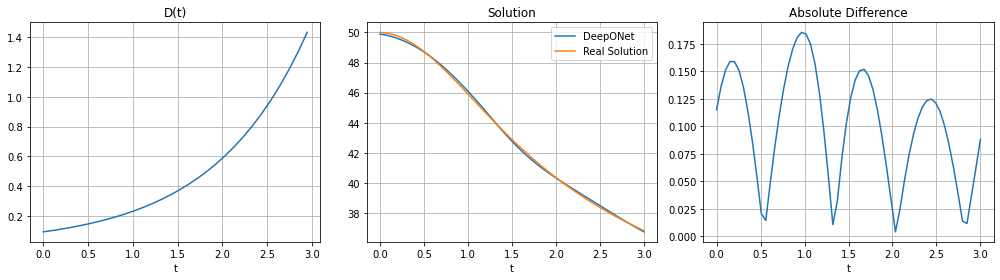

In [12]:
# Plot a solution from the test set:
plot_idx = 786

u_model = deepOnet(tp.spaces.Points(t_tensor, T), D_tensor_test[plot_idx]).as_tensor[0]
ref_solution = u_tensor_test[plot_idx]

plt.figure(0, figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(t_tensor[::2], D_tensor_test[plot_idx])
plt.title("D(t)")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(t_tensor, u_model.detach())
plt.plot(t_tensor, ref_solution)
plt.title("Solution")
plt.legend(["DeepONet", "Real Solution"])
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(t_tensor, torch.abs(ref_solution - u_model.detach()))
plt.title("Absolute Difference")
plt.xlabel("t")
plt.grid()
plt.tight_layout()

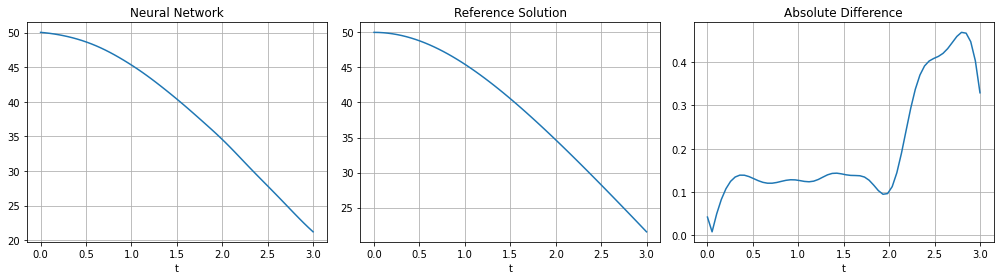

In [13]:
# Now a test for constant values of D:
test_D = 0.05

def analytic_solution(t, D):
    return 1/D * (-torch.log((1+torch.exp(-2*torch.sqrt(D*g)*t))/2) - torch.sqrt(D*g)*t) + H

# Evaluate model:
u_model = deepOnet(tp.spaces.Points(t_tensor, T), lambda t: test_D*torch.ones_like(t)).as_tensor[0]
ref_solution = analytic_solution(t_tensor, torch.tensor(test_D))
                                 
# Plot
plt.figure(0, figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(t_tensor, u_model.detach())
plt.title("Neural Network")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(t_tensor, ref_solution)
plt.title("Reference Solution")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(t_tensor, torch.abs(ref_solution - u_model.detach()))
plt.title("Absolute Difference")
plt.xlabel("t")
plt.grid()
plt.tight_layout()